# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp, quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as torch_utils

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [2]:
class LQR:
    def __init__(self, H, M, sigma, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
       

    def markov_control(self, t_batch, x_batch):
        a=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            x_batch_n = x_batch[t]
            a_ = -((torch.inverse(self.D.float()) @ self.M.T) @ S_ordered[0]) @ x_batch_n.T
            a=torch.cat((a,a_.unsqueeze(0))) 
        return a.transpose(1,2)


    def value_function(self, t_batch, x_batch):
        v=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            sigma = self.sigma
            x_batch_n = x_batch[t]

            # Compute the first term: x.transpose(S)x
            x_S_x = torch.matmul(torch.matmul(x_batch_n.unsqueeze(0), S_ordered[0]), x_batch_n.unsqueeze(0).transpose(-1, -2)).squeeze()

        # Compute the integral term using Einstein summation notation with smaller time steps
            integral_term = 0
            for i in range(len(time_grid) - 1):
                dt = time_grid[i + 1] - time_grid[i]
                int_term=sigma@sigma.T@S_ordered[i]
                trace_term = torch.einsum('bij->b',int_term.unsqueeze(0))
                integral_term += trace_term * dt

            # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
            v=torch.cat((v,x_S_x + integral_term)) 
        return v


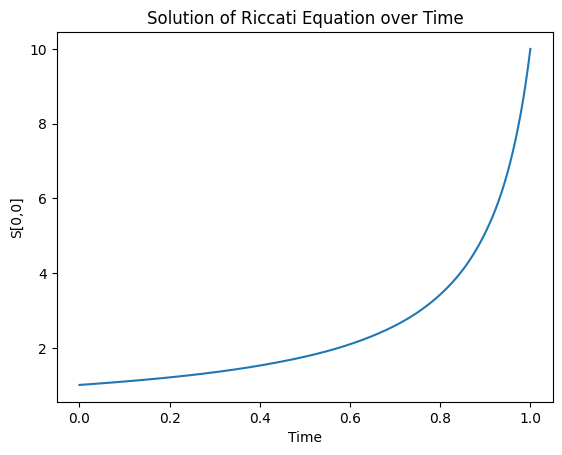

Optimal Markov Control:
tensor([[[-2.5995, -2.5995]]])
Value Function:
tensor([5.1990])


In [3]:
# Example Usage:
# Define problem matrices
# H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
# R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# T = torch.tensor(100, dtype=torch.float32)

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 10000)

lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
S_sol_v2 = S_solution.T.reshape(len(time_grid),2,2)
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# # Create sample input tensors
# t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
# x_batch = torch.tensor([
#     [[1.0, 2.0]],  
#     [[1.0, 0.0]], 
#     [[3.0, 2.0]]  
# ], dtype=torch.float32)  # Sample spatial values

t_batch = torch.tensor([0.7], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 1.0]] 
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



In [4]:
t_batch.shape, x_batch.shape

(torch.Size([1]), torch.Size([1, 1, 2]))

## Exercise 1.2

1. Error

2. Time

In [5]:
#Create error function 
def calculate_error(X1, X2):
    error = (1/len(X1))*(X1-X2)^2
    return error

In [4]:
# Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10


# Define time grid
time_grid_S = torch.linspace(0, T, 10000)
lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid_S)
S_sol_v2 = S_solution.T.reshape(len(time_grid_S),2,2).float()
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])


In [5]:
# X Generation
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    X = x0.unsqueeze(0)
    brownian = torch.randn(N_steps, 2, dtype=torch.float32)*torch.sqrt(tau)

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D) @ M.T @ S_sol_ordered[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw
        
        X=torch.cat((X,next_val.view(2, 1).unsqueeze(0))) # Ensure next_val remains a 2x1 column vector

    return X.transpose(1,2)

# Call the function with corrected inputs
N_steps = 100
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)

tensor([[[1.0000, 1.0000]],

        [[0.9908, 0.9907]],

        [[0.9818, 0.9819]],

        [[0.9728, 0.9728]],

        [[0.9639, 0.9638]],

        [[0.9552, 0.9553]],

        [[0.9464, 0.9462]],

        [[0.9377, 0.9376]],

        [[0.9292, 0.9290]],

        [[0.9205, 0.9205]],

        [[0.9122, 0.9122]],

        [[0.9037, 0.9037]],

        [[0.8956, 0.8955]],

        [[0.8875, 0.8872]],

        [[0.8793, 0.8792]],

        [[0.8711, 0.8712]],

        [[0.8632, 0.8631]],

        [[0.8553, 0.8552]],

        [[0.8474, 0.8474]],

        [[0.8397, 0.8396]],

        [[0.8321, 0.8317]],

        [[0.8244, 0.8241]],

        [[0.8166, 0.8168]],

        [[0.8093, 0.8093]],

        [[0.8017, 0.8017]],

        [[0.7944, 0.7943]],

        [[0.7872, 0.7873]],

        [[0.7802, 0.7802]],

        [[0.7728, 0.7729]],

        [[0.7659, 0.7658]],

        [[0.7589, 0.7588]],

        [[0.7520, 0.7518]],

        [[0.7449, 0.7448]],

        [[0.7380, 0.7381]],

        [[0.73

/tmp/ipykernel_1502/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


### Exercise 1.2.1

For our error measure we will use the Mean Squared Error (MSE).  This is a computationally simple function. We take the difference between the model's predictions and the true value, squaring it and averaging it over the dataset. We use this method for calculating the error because it ensures there are no large outliers in the model's calculation because of squaring of the values. This being said, if our model makes one bad prediction, the error is magnifide so one outlier will dramatically impact the error value. 

### Exercise 1.2.2

In [10]:
# 1.2.2 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

N_samples=100 #CHANGE FOR LOCAL RUNNING
N_steps=[1, 10, 50, 100, 500, 1000, 5000]
cost=torch.tensor([])
S_sol_cs = CubicSpline(time_grid_S, S_sol_ordered)
exp_cost=torch.tensor([])
for t in range(len(N_steps)):
    time_grid = torch.linspace(0, T, N_steps[t]+1)
    dt= time_grid[1:]-time_grid[:-1]
    S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)
    for i in range(N_samples):
        result = generate_x(T, N_steps[t]+1, H.float(), M.float(), D.float(), 
                            S_sol_cs_vals.float(), sigma.float(), x0)
        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)
        J = torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost=torch.cat((cost,J))
    exp_cost=torch.cat((exp_cost,torch.mean(cost).unsqueeze(0)))

/tmp/ipykernel_1172/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


KeyboardInterrupt: 

In [9]:
# OUR FIRST 1.2 BABY :D

def calculate_mse(X1, X2):
    count = 0
    MSE = []
    SE = 0

    for i in range(len(X2)):
        SE += (X2.data[i]-X1)**2
        count+=1
    return SE/count


print(calculate_mse(exp_cost, value_func))


#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

tensor([638.7959, 161.9492,  69.0262,  37.0251,  22.3398,  14.4481,   8.9660])


NameError: name 'error' is not defined

Exercise 1.2.3

In [ ]:
# 1.2.3 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

#N_samples=[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000] #DO NOT RUN
N_samples = [10,50,100,250,500,750,1000]
N_steps = 5000
cost_samples = torch.tensor([])
exp_cost_samples = torch.tensor([])

# Time grid specifications
time_grid = torch.linspace(0, T, N_steps+1)
dt = time_grid[1:]-time_grid[:-1]
S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)

for j in range(len(N_samples)):
    for i in range(N_samples[j]):
        result = generate_x(T, N_steps+1, H.float(), M.float(), D.float(), 
        S_sol_cs_vals.float(), sigma.float(), x0)

        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)

        J = result[-1]@R@result[-1].T + torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost_samples=torch.cat((cost_samples,J))
    
    exp_cost_samples=torch.cat((exp_cost_samples,torch.mean(cost_samples).unsqueeze(0)))

NameError: name 'S_sol_cs' is not defined

tensor([5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072, 5.1072])


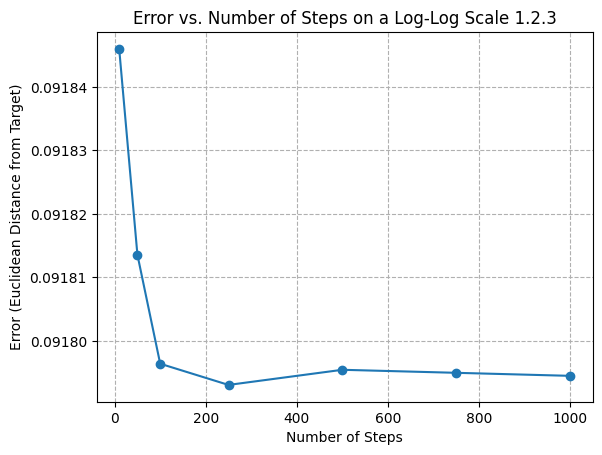

In [ ]:
# OUR FIRST 1.2.3 BABY :D

print(exp_cost_samples) # why is the first one better than the second?

# Compute the error
error_samples = abs(exp_cost_samples-value_func)

#Plot the error
plt.plot(N_samples, error_samples, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale 1.2.3')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 2

In [4]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32).unsqueeze(-1).transpose(1,2)
    return t, x

In [10]:
# Function to train the neural network
def train_net_dgm(net_dgm, t_train, x_train, epochs=300, lr=0.001):
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()
    tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
    losses = np.array([])

    for epoch in range(epochs):
        optimizer.zero_grad()
        v_real=lqr_system.value_function(t_train, x_train).unsqueeze(1)
        v_pred = net_dgm(v_real,tx_train)  # Predict value function
        loss = criterion(v_pred, v_real)  # Compute loss
        loss.backward()
        optimizer.step()
        losses= np.append(losses,loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 1
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
vf=lqr_system.value_function(t_train, x_train)

# Initialize the neural network
net_dgm = Net_DGM(dim_x=3, dim_S=100, hidden_size=100)

# Train the neural network
losses = train_net_dgm(net_dgm, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Epoch 0, Loss: 319.6103515625


KeyboardInterrupt: 

In [9]:
# do we need this?
print(lqr_system.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float())

tensor([[[10.0000,  0.0000],
         [ 0.0000, 10.0000]],

        [[ 9.9902,  0.0000],
         [ 0.0000,  9.9902]],

        [[ 9.9804,  0.0000],
         [ 0.0000,  9.9804]],

        ...,

        [[ 1.0147,  0.0000],
         [ 0.0000,  1.0147]],

        [[ 1.0147,  0.0000],
         [ 0.0000,  1.0147]],

        [[ 1.0146,  0.0000],
         [ 0.0000,  1.0146]]])


tensor([[[-3.2860,  1.7188]],

        [[ 1.8760, -2.5800]],

        [[-2.1910, -2.5670]],

        [[ 1.9268,  4.2963]],

        [[ 2.9776,  1.6693]],

        [[ 5.0712, -6.8930]],

        [[-2.6924,  0.5434]],

        [[-0.1176,  1.7335]],

        [[-2.5575, -3.0802]],

        [[ 2.9352,  0.6273]]])
Epoch 0, Loss: 9.136303901672363
Epoch 100, Loss: 0.010703633539378643
Epoch 200, Loss: 0.0015511864330619574


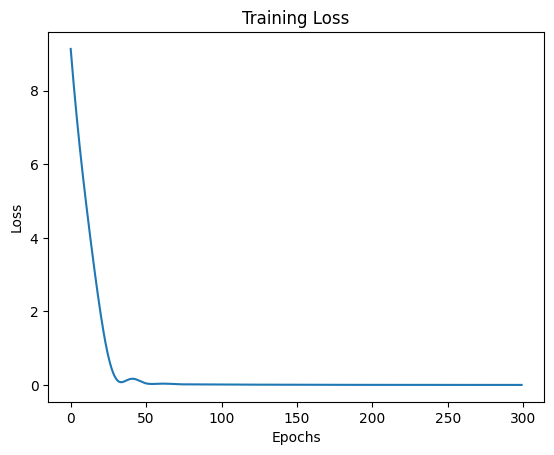

In [7]:
# Function to train the neural network
def train_ffn_net(net_ffn, t_train, x_train, epochs=300, lr=0.001):
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
    # criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        a_real=lqr_system.markov_control(t_train, x_train).squeeze(1)
        a_pred = net_ffn(torch.cat((a_real, tx_train),dim=1))  # Predict markov control
        loss = nn.MSELoss()(a_pred, a_real)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 1
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.markov_control(t_train, x_train))

# Define the sizes for the FFN network
sizes = [5, 100, 100, 2]  # Input size is 4 (markov control + time + 2 x), 2 hidden layers of size 100, output size is 2

# Initialize the neural network
net_ffn = FFN(sizes)

# Train the neural network
losses = train_ffn_net(net_ffn, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [8]:
a_real=lqr_system.markov_control(t_train, x_train).squeeze(1)
tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
a_real,tx_train

(tensor([[-3.2860,  1.7188],
         [ 1.8760, -2.5800],
         [-2.1910, -2.5670],
         [ 1.9268,  4.2963],
         [ 2.9776,  1.6693],
         [ 5.0712, -6.8930],
         [-2.6924,  0.5434],
         [-0.1176,  1.7335],
         [-2.5575, -3.0802],
         [ 2.9352,  0.6273]]),
 tensor([[ 0.1513,  2.8354, -1.4831],
         [ 0.3501, -1.3048,  1.7945],
         [ 0.5410,  1.1583,  1.3571],
         [ 0.4695, -1.1406, -2.5433],
         [ 0.7287, -1.0664, -0.5978],
         [ 0.6471, -2.1946,  2.9829],
         [ 0.2946,  2.0005, -0.4038],
         [ 0.0333,  0.1128, -1.6620],
         [ 0.0911,  2.3320,  2.8087],
         [ 0.4610, -1.7593, -0.3760]]))

In [5]:
class PDE():
    def __init__(self, net, T, sigma, H, M, C, D, R, alpha):
        self.net = net
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.alpha = alpha
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 1)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        # t1 = torch.matmul(u_x, torch.matmul(self.H, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        t2 = (torch.matmul(u_x, torch.matmul(self.M, self.alpha.T))).T.unsqueeze(1)
        x = x.unsqueeze(1).detach()
        # t3 = (torch.matmul(x, torch.matmul(self.C, x.T)).sum(dim=1)).unsqueeze(1)
        t3 = torch.matmul(x, torch.matmul(self.C, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        t4 = torch.matmul(self.alpha.T, torch.matmul(self.D, self.alpha)).expand_as(trace_term)

        # Compute the PDE residual term
        pde_res = (
            u_t + trace_term + t1 + t2 + t3 + t4
        )

        return pde_res


    def boundary_condition(self, x):
        # Compute the boundary condition term
        T = torch.full_like(x[:, :1], self.T.item())  # Create a tensor of the same size as x with values T
        u_final = self.net(T, x)  # Evaluate the neural network output at the final time T
        # R = torch.cat([self.R.unsqueeze(0) for i in range(num_samples)], dim=0)
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        return u_final - cond



In [6]:
class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim) 
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        hidden3 = self.activation(self.fc3(hidden2)) 
        output = self.fc4(hidden3)
        return output

def loss_function(u, t, x, linear_pde):
    pde_residual = torch.abs(linear_pde.pde_residual(t, x))
    boundary_term = torch.abs(linear_pde.boundary_condition(x))
    
    # Compute MSE loss
    pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
    boundary_loss = F.mse_loss(boundary_term, torch.zeros_like(boundary_term))
    
    # Total loss is the sum of MSE losses
    loss = pde_loss + boundary_loss
    return loss    


def train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor=0.1, lr_decay_epochs=500):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, linear_pde)
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())  # Store the loss value
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            # print(f"learning rate: {scheduler.get_last_lr()[0]}")

    # Calculate normalized losses
    # losses = [loss / len(t_train) for loss in losses]

    return losses



In [9]:
# Define hyperparameters
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 150 # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 100  # Number of training samples
T = torch.tensor([1], dtype=torch.float32)  # End time
epochs = 1500  # Number of training epochs
lr = 1e-2  # Learning rate
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)
lr_decay_factor = 0.2  # Factor by which the learning rate is reduced
lr_decay_epochs = 200  # Number of epochs after which the learning rate is reduced

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Create an instance of the HeatEquation2D class
linear_pde = PDE(model, T, sigma, H, M, C, D, R, alpha)

# Generate training data
t_train = torch.rand(num_samples, 1) * T
x_train = torch.rand(num_samples, 2)  # Assuming 2D space

# Train the DGM model
losses = train_dgm(model, t_train, x_train, linear_pde, epochs, lr, lr_decay_factor, lr_decay_epochs)


Epoch 0, Loss: 71.0228042602539
Epoch 100, Loss: 15.970669746398926
Epoch 200, Loss: 6.197561264038086
Epoch 300, Loss: 0.11825928092002869
Epoch 400, Loss: 0.12516215443611145
Epoch 500, Loss: 0.033369556069374084
Epoch 600, Loss: 0.049579180777072906
Epoch 700, Loss: 0.01945657655596733
Epoch 800, Loss: 0.014370852150022984
Epoch 900, Loss: 0.012876402586698532
Epoch 1000, Loss: 0.011552151292562485
Epoch 1100, Loss: 0.011301030404865742
Epoch 1200, Loss: 0.011046078987419605
Epoch 1300, Loss: 0.010993791744112968
Epoch 1400, Loss: 0.01093972660601139


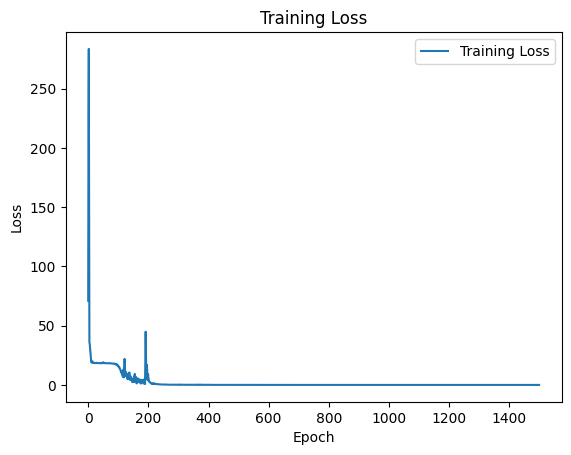

In [10]:
# Plot the losses
plt.plot(range(epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
# Function to compute the error between the model prediction and Monte Carlo solution
def compute_error(model, t, x, alpha, R):
    u_pred = model(t, x)
    mc_solution = monte_carlo_solution(x, alpha, R)
    error = torch.abs(u_pred - mc_solution)
    return error


# Plot the error against the Monte Carlo solution
plt.subplot(1, 2, 2)
plt.plot(range(0, epochs, interval), errors, label='Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error against Monte Carlo Solution')
plt.legend()

plt.tight_layout()
plt.show()

Exercise 4

In [11]:
class ValueFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ValueFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()
    
    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        output = self.fc2(hidden1)
        return output

class ControlFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ControlFunction, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()
    
    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        output = self.fc2(hidden1)
        return output


In [19]:
class PDE:
    def __init__(self, net_val, net_act, T, sigma, H, M, C, D, R):
        self.net_val = net_val  # Value function approximation network
        self.net_act = net_act  # Control function approximation network
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net_val(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the trace term
        trace_term = 0.5 * torch.trace(torch.matmul(self.sigma, self.sigma.T)) * u_xx.sum(dim=1, keepdim=True)  # (batch, 1)
        t1 = (u_x @ self.H @ x.T).sum(dim=1).unsqueeze(1)
        t2 = (u_x @ (self.M @ self.net_act(t, x).T)).sum(dim=1, keepdim=True)
        t3 = (x @ self.C @ x.T).sum(dim=1).unsqueeze(1)
        t4 = (self.net_act(t, x) @ self.D @ self.net_act(t, x).T).sum(dim=1, keepdim=True)

        
        pde_res = (
            u_t + trace_term + t1 + t2 + t3 + t4
        )

        return pde_res

    def boundary_condition(self, x):
        # Compute the boundary condition term
        T = torch.full_like(x[:, :1], self.T.item())  # Create a tensor of the same size as x with values T
        u_final = self.net_val(T, x)  # Evaluate the neural network output at the final time T
        # R = torch.cat([self.R.unsqueeze(0) for i in range(num_samples)], dim=0)
        x = x.unsqueeze(1).detach()
        cond = torch.matmul(x, torch.matmul(self.R, x.reshape(num_samples, 2, 1))).reshape(num_samples, 1)
        return u_final - cond

    def update_value_function(self, optimizer_val, t_train, x_train):
        optimizer_val.zero_grad()
        pde_residual = torch.abs(self.pde_residual(t_train, x_train))
        boundary_res = torch.abs(self.boundary_condition(x_train))

        # Compute MSE loss
        pde_loss = F.mse_loss(pde_residual, torch.zeros_like(pde_residual))
        boundary_loss = F.mse_loss(boundary_res, torch.zeros_like(boundary_res))
        
        # Total loss is the sum of MSE losses
        loss = pde_loss + boundary_loss

        loss.backward()
        optimizer_val.step()
        
        return loss.item()
    

    def update_control_function(self, optimizer_act, t_train, x_train):
        optimizer_act.zero_grad()

        # Compute the output of net_val at (t_train, x_train)
        u = self.net_val(t_train, x_train)

        # Compute the gradients of u with respect to x_train
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        
        # Compute the Hamiltonian
        h1 = (u_x @ self.H @ x_train.T)
        h2 = u_x @ self.M @ self.net_act(t_train, x_train).T
        h3 = x_train @ self.C @ x_train.T
        h4 = self.net_act(t_train, x_train) @ self.D @ self.net_act(t_train, x_train).T

        hamiltonian = h1 + h2 + h3 + h4

        # Minimize the negative mean of the Hamiltonian
        loss = torch.mean(hamiltonian)

        # Backpropagation and optimization step
        loss.backward()
        optimizer_act.step()

        return loss.item()

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def policy_iteration(net_val, net_act, pde, t_train, x_train, epochs_val, epochs_act, lr_val, lr_act, lr_decay_epochs, lr_decay_factor):
    optimizer_val = optim.Adam(net_val.parameters(), lr=lr_val)
    optimizer_act = optim.Adam(net_act.parameters(), lr=lr_act)
    
    scheduler_val = StepLR(optimizer_val, step_size=lr_decay_epochs, gamma=lr_decay_factor)
    scheduler_act = StepLR(optimizer_act, step_size=lr_decay_epochs, gamma=lr_decay_factor)

    for epoch in range(epochs_val):
        loss_val = pde.update_value_function(optimizer_val, t_train, x_train)
        scheduler_val.step()  # Update learning rate
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Value Function Update: Loss = {loss_val}, Learning Rate = {scheduler_val.get_last_lr()}')

    # for epoch in range(epochs_act):
    #     loss_act = pde.update_control_function(optimizer_act, t_train, x_train)
    #     scheduler_act.step()  # Update learning rate
    #     if epoch % 100 == 0:
    #         print(f'Epoch {epoch}, Control Function Update: Loss = {loss_act}, Learning Rate = {scheduler_act.get_last_lr()}')

# Initialize value function and control function networks
net_val = ValueFunction(input_dim=3, hidden_dim=150, output_dim=1)
net_act = ControlFunction(input_dim=3, hidden_dim=150, output_dim=2)

T = torch.tensor([1], dtype=torch.float32)
# Initialize PDE solver with networks and other parameters
pde = PDE(net_val, net_act, T, sigma, H, M, C, D, R)

# Generate training data (sampled from [0, T) x R^2)
t_train = torch.rand(num_samples, 1) * pde.T
x_train = torch.rand(num_samples, 2)

# Hyperparameters for learning rate scheduler
lr_decay_epochs = 200
lr_decay_factor = 0.2

# Run policy iteration algorithm with learning rate scheduler
policy_iteration(net_val, net_act, pde, t_train, x_train, epochs_val=1000, epochs_act=1000, lr_val=1e-2, lr_act=1e-2, 
                 lr_decay_epochs=lr_decay_epochs, lr_decay_factor=lr_decay_factor)


Epoch 0, Value Function Update: Loss = 27.220481872558594, Learning Rate = [0.01]
Epoch 100, Value Function Update: Loss = 0.011305071413516998, Learning Rate = [0.01]
Epoch 200, Value Function Update: Loss = 0.00483657605946064, Learning Rate = [0.002]
Epoch 300, Value Function Update: Loss = 0.004359089303761721, Learning Rate = [0.002]
Epoch 400, Value Function Update: Loss = 0.003919098526239395, Learning Rate = [0.0004]
Epoch 500, Value Function Update: Loss = 0.003832685761153698, Learning Rate = [0.0004]
Epoch 600, Value Function Update: Loss = 0.0037399984430521727, Learning Rate = [8e-05]
Epoch 700, Value Function Update: Loss = 0.003720016684383154, Learning Rate = [8e-05]
Epoch 800, Value Function Update: Loss = 0.003698301035910845, Learning Rate = [1.6000000000000003e-05]
Epoch 900, Value Function Update: Loss = 0.003693575505167246, Learning Rate = [1.6000000000000003e-05]
